In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

In [13]:
model = "resnet18std"
dataset = "cifar100"
exp_name = f"{dataset}_{model}"

In [14]:
# Provide the path to your CSV file
csv_path = f"likelihood_T_{dataset}_{model}.csv"

# Use the read_csv() function to import the CSV file
data_frame = pd.read_csv(csv_path)

In [15]:
lambs = np.linspace(0.5, 3.5, 7)

[0.01246266 0.01111107 0.00410557 0.0038314  0.00743226 0.00416293
 0.00568807]
[0.01434299 0.00704339 0.00220121 0.00305951 0.00070681 0.0029439
 0.00530394]
[       nan 0.00972981 0.00438516 0.00822885 0.00698741 0.00463243
 0.00053872]
[0.02825644 0.0090551  0.00975247 0.00548533 0.00441612 0.00259691
 0.00169927]
[0.02826169 0.025146   0.03254087 0.03475971 0.07378413 0.08381406
 0.03633569]


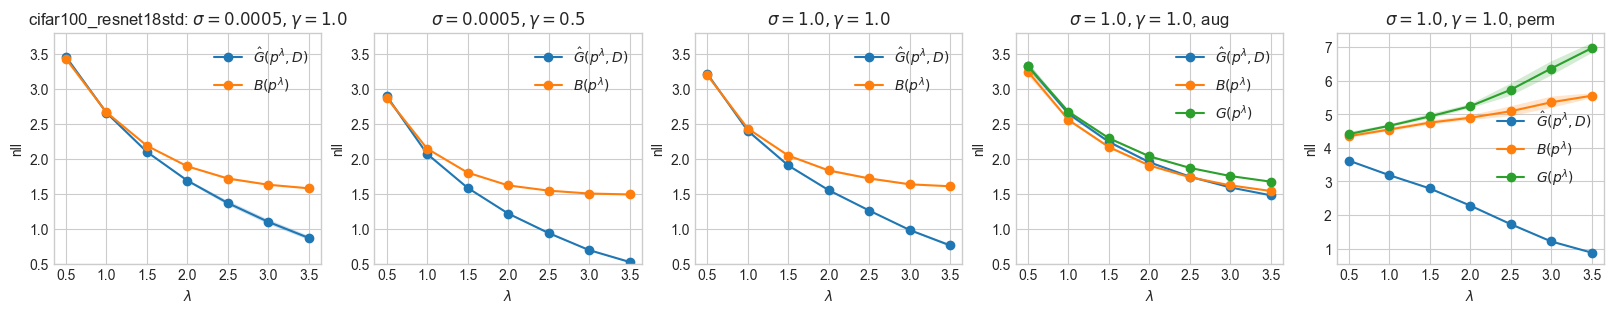

In [19]:
settings = ["base", "likelihood", "prior", "aug", "perm"]

fig=plt.figure(figsize=(20,3))
for i in range(len(settings)):
    this_setting=settings[i]
    fig.add_subplot(1, 5, i+1)
    if this_setting == "base":
        condition1 = data_frame["prior_scale"] == 0.0005
        condition2 = data_frame["logits_temp"] == 1.0
        condition3 = data_frame["augment"] == False
        condition4 = data_frame["perm"] == False

        gamma = 0.0005
        sigma = 1.0

    elif this_setting == "likelihood":
        condition1 = data_frame["prior_scale"] == 0.0005
        condition2 = data_frame["logits_temp"] == 0.5
        condition3 = data_frame["augment"] == False
        condition4 = data_frame["perm"] == False

        gamma = 0.0005
        sigma = 0.5

    elif this_setting == "prior":
        condition1 = data_frame["prior_scale"] == 1.0
        condition2 = data_frame["logits_temp"] == 1.0
        condition3 = data_frame["augment"] == False
        condition4 = data_frame["perm"] == False

        gamma = 1.0
        sigma = 1.0

    elif this_setting == "aug":
        condition1 = data_frame["prior_scale"] == 1.0
        condition2 = data_frame["logits_temp"] == 1.0
        condition3 = data_frame["augment"] == True
        condition4 = data_frame["perm"] == False

        gamma = 1.0
        sigma = 1.0

    elif this_setting == "perm":
        condition1 = data_frame["prior_scale"] == 1.0
        condition2 = data_frame["logits_temp"] == 1.0
        condition3 = data_frame["augment"] == False
        condition4 = data_frame["perm"] == True

        gamma = 1.0
        sigma = 1.0

    # Combine the conditions using logical operators
    combined_condition = condition1 & condition2 & condition3 & condition4

    # Apply the combined condition to filter the DataFrame
    filtered_data = data_frame[combined_condition]

    grouped_data = filtered_data.groupby(["likelihood_T"])

    bayes_test_mean = np.array(grouped_data["sgld/test/bma_bayes_loss"].mean())[::-1]
    bayes_test_ste = np.array(grouped_data["sgld/test/bma_bayes_loss"].agg("sem"))[::-1]
    print(bayes_test_ste)

    gibbs_train_mean = np.array(grouped_data["sgld/train/bma_gibbs_loss"].mean())[::-1]
    gibbs_train_ste = np.array(grouped_data["sgld/train/bma_gibbs_loss"].agg("sem"))[
        ::-1
    ]

    # plt.figure(figsize=(3, 2))

    plt.plot(
        np.arange(0, len(lambs), 1),
        gibbs_train_mean,
        label=r"$\hat G(p^\lambda,D)$",
        marker="o",
    )
    plt.fill_between(
        np.arange(0, len(lambs), 1),
        gibbs_train_mean + 2 * gibbs_train_ste,
        gibbs_train_mean - 2 * gibbs_train_ste,
        alpha=0.2,
    )

    plt.plot(
        np.arange(0, len(lambs), 1),
        bayes_test_mean,
        label=r"$B(p^\lambda)$",
        marker="o",
    )
    plt.fill_between(
        np.arange(0, len(lambs), 1),
        bayes_test_mean + 2 * bayes_test_ste,
        bayes_test_mean - 2 * bayes_test_ste,
        alpha=0.2,
    )
    if this_setting == "base":
        plt.title(exp_name + r": $\sigma=0.0005, \gamma=1.0$")
    elif this_setting == "likelihood":
        plt.title(r"$\sigma=0.0005, \gamma=0.5$")
    elif this_setting == "prior":
        plt.title(r"$\sigma=1.0, \gamma=1.0$")
    else:
        gibbs_test_mean = np.array(grouped_data["sgld/test/bma_gibbs_loss"].mean())[
            ::-1
        ]
        gibbs_test_ste = np.array(grouped_data["sgld/test/bma_gibbs_loss"].agg("sem"))[
            ::-1
        ]
        plt.plot(
            np.arange(0, len(lambs), 1),
            gibbs_test_mean,
            label=r"$G(p^\lambda)$",
            marker="o",
        )
        plt.fill_between(
            np.arange(0, len(lambs), 1),
            gibbs_test_mean + 2 * gibbs_test_ste,
            gibbs_test_mean - 2 * gibbs_test_ste,
            alpha=0.2,
        )
        if this_setting == "aug":
            plt.title(r"$\sigma=1.0, \gamma=1.0$, aug")
        elif this_setting == "perm":
            plt.title(r"$\sigma=1.0, \gamma=1.0$, perm")

    plt.legend()
    plt.xticks(np.arange(0, len(lambs), 1), lambs)
    plt.xlabel(r"$\lambda$")

    if this_setting != "perm":
        # mnist_lenetbig
        # mnist_lenetsmall
        plt.ylim(0.5,3.8)
    plt.ylabel("nll")
    plt.plot()

    # if this_setting == "aug":
    #     plt.savefig(f"{exp_name}_{sigma}_{gamma}_true_false.png", dpi=1000, bbox_inches="tight")
    # elif this_setting == "perm":
    #     plt.savefig(f"{exp_name}_{sigma}_{gamma}_false_true.png", dpi=1000, bbox_inches="tight")
    # else:
    #     plt.savefig(f"{exp_name}_{sigma}_{gamma}_false_false.png", dpi=1000, bbox_inches="tight")
plt.savefig(f"{exp_name}", dpi=1000, bbox_inches="tight")

